In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys
path = os.getcwd()
while not path.endswith('research'):    
    path = os.path.abspath(os.path.join(path, '../'))
sys.path.append(path)

***

In [3]:
#a number of gas analytics utilities:
from gmt.fom.gas.shared.utils.common import print_attributes as pa
from gmt.fom.gas.shared.utils.common import display_full_df as ddff
from gmt.fom.gas.shared.utils.common import flatten_lst

In [4]:
#gas aligned mongo db
from gmt.fom.gas.shared.utils.mongo import GasMongo

In [5]:
import logging
logging.getLogger().setLevel(logging.INFO)

***

In [6]:
import os, sys
import numpy as np

from datetime import datetime, date

In [7]:
import pandas as pd

In [8]:
import matplotlib.pyplot as plt

In [9]:
import statsmodels.api as sm

# Time Series Modelling

In statistics and quantitative research methodology, a sample is a set of individuals or objects collected or selected from a statistical population by a defined procedure

In mathematical terms, given a probability distribution F, a random sample of length n (where n may be any positive integer) is a set of realizations of n independent, identically distributed (iid) random variables with distribution F.

In probability theory and statistics, a collection of random variables is independent and identically distributed if each random variable has the same probability distribution as the others and all are mutually independent

In statistics, it is commonly assumed that observations in a sample are effectively i.i.d

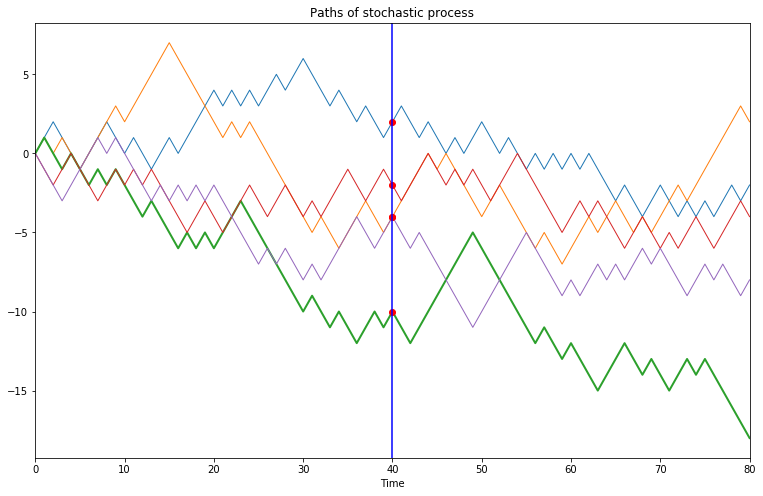

In [261]:
N=5
paths = []
for i in range(N):
    dims = 1
    step_n = 80
    step_set = [-1, 1]
    origin = np.zeros((1,dims))
    # Simulate steps in 1D
    step_shape = (step_n,dims)
    steps = np.random.choice(a=step_set, size=step_shape)
    path = np.concatenate([origin, steps]).cumsum(0)
    start = path[:1]
    stop = path[-1:]
    paths.append(path)

# Plot the path
fig = plt.figure(figsize=(8*1.6,8))
ax = fig.add_subplot(111)

k = int(step_n/2)
for i in range(len(paths)):
    if i == 2:
        ax.plot(paths[i],lw=2)
    else:
        ax.plot(paths[i],lw=1)
    ax.set_xlim(0, step_n)
    ax.plot(k, paths[i][k], c='red', marker='o')
    
ax.set_xlabel('Time')
ax.set_title('Paths of stochastic process')
plt.axvline(k, color='b')
plt.show()

# Folders

In [170]:
folder_data = os.path.join(os.getcwd(), 'data'); folder_data

'C:\\git\\gmt-fom-gas-research\\sandbox\\alexs\\python_workshop\\modelling_in_python\\data'

In [171]:
folder_results = os.path.join(os.getcwd(), 'results'); folder_results

'C:\\git\\gmt-fom-gas-research\\sandbox\\alexs\\python_workshop\\modelling_in_python\\results'

# Data

In [172]:
df_google = pd.read_csv(os.path.join(folder_data, 'google.csv')); df_google.head()

day ticker   name  ccy   indx         open         high  \
0  2021-01-05  GOOGL  GOOGL  USD  SP500  1725.089966  1746.829956   
1  2021-01-04  GOOGL  GOOGL  USD  SP500  1760.000000  1762.489990   
2  2020-12-31  GOOGL  GOOGL  USD  SP500  1737.270020  1757.500000   
3  2020-12-30  GOOGL  GOOGL  USD  SP500  1765.000000  1767.760010   
4  2020-12-29  GOOGL  GOOGL  USD  SP500  1787.229980  1788.469971   

           low        close     volume   closeunadj  
0  1716.900024  1740.050049  1015942.0  1740.050049  
1  1707.140015  1726.130005  1866195.0  1726.130005  
2  1736.089966  1752.640015  1053479.0  1752.640015  
3  1728.000000  1736.250000  1051308.0  1736.250000  
4  1755.109985  1757.760010   982077.0  1757.760010

In [173]:
df_sp500 = pd.read_csv(os.path.join(folder_data, 'sp500_index.csv')); df_sp500.head()

day      ticker        name  ccy   indx         open  high  low  \
0  2020-10-12  SP500Index  SP500Index  USD  SP500  3534.219971   NaN  NaN   
1  2020-10-09  SP500Index  SP500Index  USD  SP500  3477.129883   NaN  NaN   
2  2020-10-08  SP500Index  SP500Index  USD  SP500  3446.830078   NaN  NaN   
3  2020-10-07  SP500Index  SP500Index  USD  SP500  3419.449951   NaN  NaN   
4  2020-10-06  SP500Index  SP500Index  USD  SP500  3360.949951   NaN  NaN   

         close  volume  closeunadj  
0  3534.219971     NaN         NaN  
1  3477.129883     NaN         NaN  
2  3446.830078     NaN         NaN  
3  3419.449951     NaN         NaN  
4  3360.949951     NaN         NaN

# Exploratory Analysis

In [174]:
# we see that day is 'object' - we need to convert to datetime
df_google.dtypes.to_frame();

**`pd.to_datetime()`**

In [175]:
df_google['day'] = pd.to_datetime(df_google['day'])

df_google.head(1)

day ticker   name  ccy   indx         open         high          low  \
0 2021-01-05  GOOGL  GOOGL  USD  SP500  1725.089966  1746.829956  1716.900024   

         close     volume   closeunadj  
0  1740.050049  1015942.0  1740.050049

In [176]:
df_sp500['day'] = pd.to_datetime(df_sp500['day'])

df_sp500.head(1)

day      ticker        name  ccy   indx         open  high  low  \
0 2020-10-12  SP500Index  SP500Index  USD  SP500  3534.219971   NaN  NaN   

         close  volume  closeunadj  
0  3534.219971     NaN         NaN

**`describe()`**

In [177]:
df_google.describe().style.format('{:.2f}')

**let's day column to be index of the dataFrame**

In [178]:
df_google.set_index('day', inplace=True)
df_sp500.set_index('day', inplace=True)

**plots**

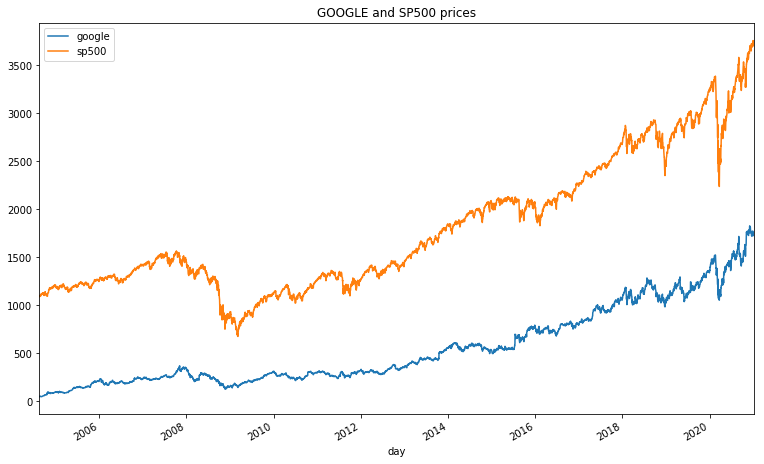

In [179]:
fig, ax = plt.subplots()
df_google['close'].plot(figsize=(8*1.6,8), ax=ax, label='google')

# df_sp500['close'].plot(figsize=(8*1.6,8), ax=ax, label='sp500')

##----------------------- ALIGN TIME SERIES -------------------------- ##
idx = df_google.index
df_sp500.loc[idx]['close'].plot(figsize=(8*1.6,8), ax=ax, label='sp500')
#-----------------------------------------------------------------------#

ax.set_title('GOOGLE and SP500 prices')
ax.legend()
plt.show()

# Stationarity and Transformations

In [180]:
google_close = df_google['close']

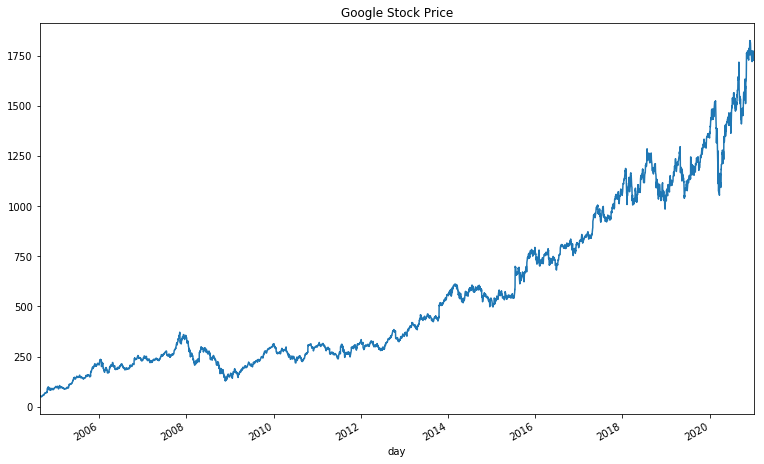

In [181]:
df_google['close'].plot(figsize=(8*1.6,8), title='Google Stock Price')

**Sample Autocorrelation | Partial autocorrelation functions**

ACF is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values. We plot these values along with the confidence band and tada! We have an ACF plot. In simple terms, it describes how well the present value of the series is related with its past values. A time series can have components like trend, seasonality, cyclic and residual. ACF considers all these components while finding correlations hence it’s a ‘complete auto-correlation plot’.

PACF is a partial auto-correlation function. Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation. So if there is any hidden information in the residual which can be modeled by the next lag, we might get a good correlation and we will keep that next lag as a feature while modeling. Remember while modeling we don’t want to keep too many features which are correlated as that can create multicollinearity issues. Hence we need to retain only the relevant features.

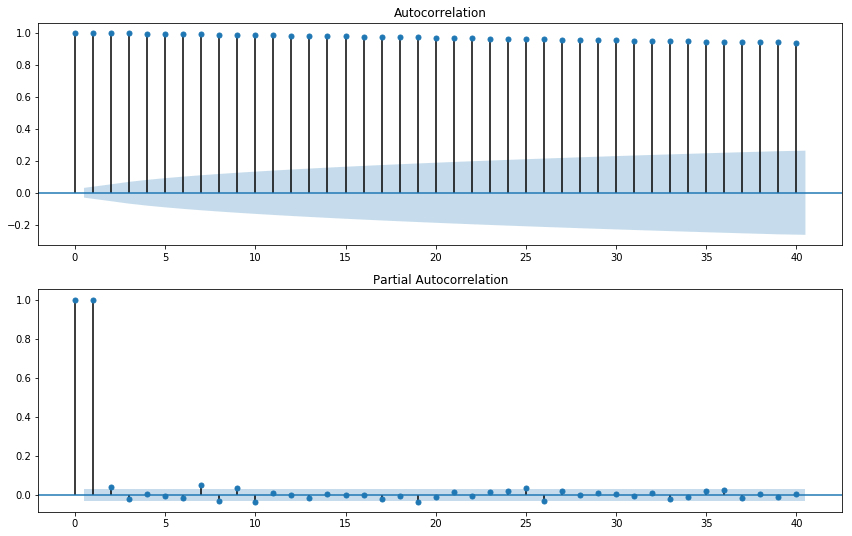

In [182]:
fig = plt.figure(figsize=(9*1.6,9))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(google_close, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(google_close, lags=40, ax=ax2)

*the time series is clearly non-stationary, so we need to transform to obtain (weakly) stationarity*

In [183]:
google_rt = np.log(google_close.sort_index(ascending=True).divide(google_close.sort_index(ascending=True).shift(1))).sort_index(ascending=False)
google_rt = google_rt[~google_rt.isnull()]

In [184]:
pd.DataFrame(pd.concat([google_close, google_rt], axis=1).reset_index().values, columns=['day', 'close', 'r_t']).set_index('day').sort_index(ascending=False).head()

close         r_t
day                            
2021-01-05  1740.05  0.00803197
2021-01-04  1726.13  -0.0152413
2020-12-31  1752.64  0.00939562
2020-12-30  1736.25  -0.0123127
2020-12-29  1757.76 -0.00917404

In [185]:
np.log(1740.05/1726.13)

0.008031939964980766

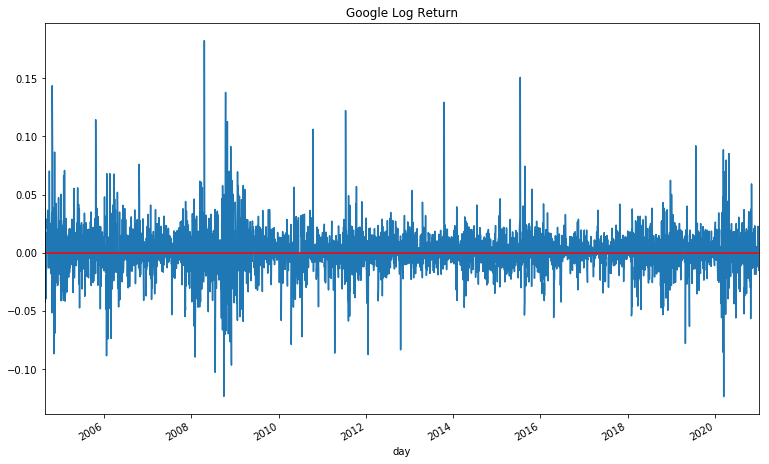

In [186]:
fig, ax = plt.subplots()
google_rt.plot(figsize=(8*1.6,8), title='Google Log Return', ax=ax)
x_vals = ax.get_xticks()
plt.axhline(0.0, color='r')
plt.show()

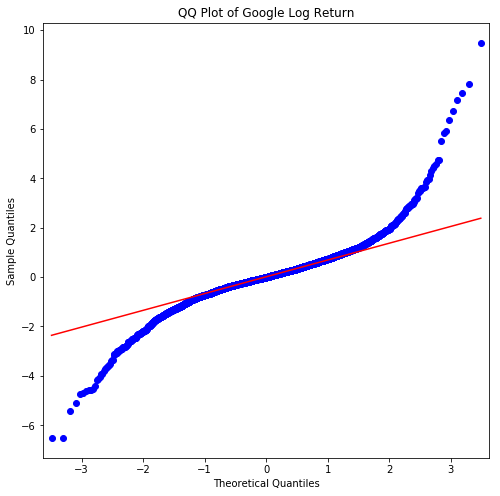

In [187]:
fig, ax = plt.subplots(figsize=(8,8))
sm.graphics.qqplot(google_rt, line='q', fit=True, ax=ax)
ax.set_title('QQ Plot of Google Log Return')
plt.show()

In [191]:
from sklearn.model_selection import TimeSeriesSplit


In [245]:
tscv = TimeSeriesSplit(n_splits=9)

In [199]:
X = google_rt
y = google_rt

In [208]:
X = X.sort_index(ascending=True)

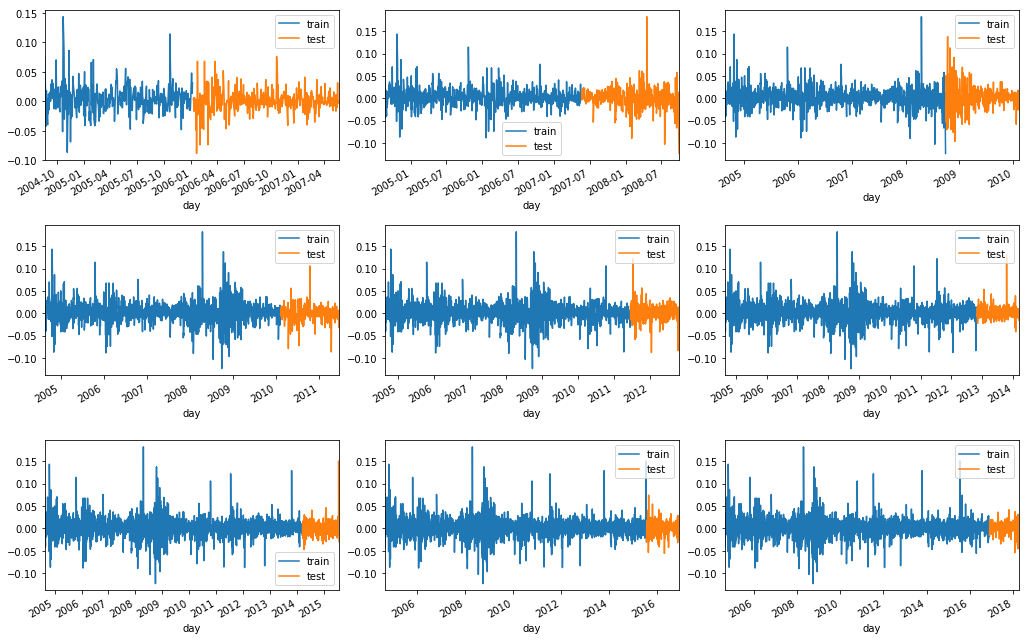

In [255]:
fig, axs = plt.subplots(3,3, figsize=(9*1.6,9))
i=j=0
for train_index, test_index in tscv.split(google_rt):    
    X_train, X_test = X[train_index], X[test_index]
    X_train.plot(ax=axs[i,j], label='train')
    X_test.plot(ax=axs[i,j], label='test')
    axs[i,j].legend()        
    j+=1
    if j%3==0:
        i+=1
        j=0
plt.tight_layout()
plt.show()

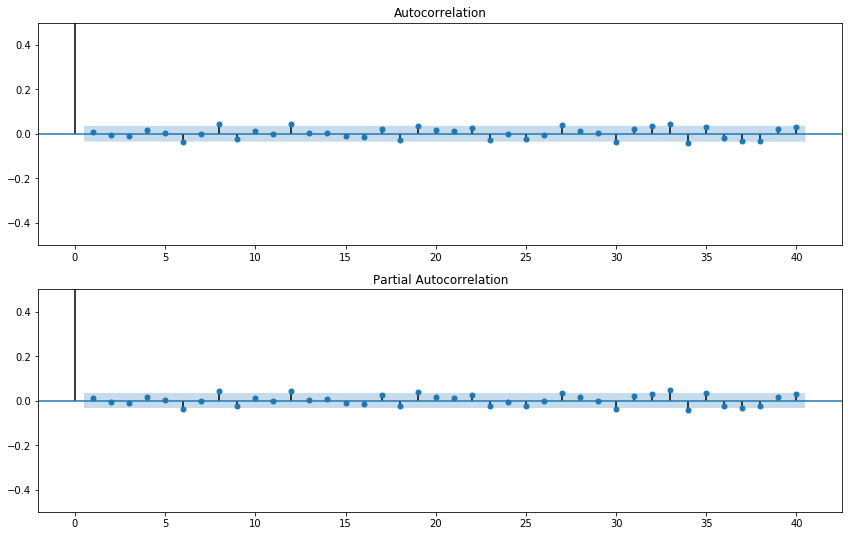

In [263]:
fig = plt.figure(figsize=(9*1.6,9))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X_train, lags=40, ax=ax1)
ax1.set_ylim(-0.5,0.5)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X_train, lags=40, ax=ax2, method='ols')
ax2.set_ylim(-0.5,0.5)
plt.show()

https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8

C:\Users\ashubert\Anaconda3\envs\gas_research\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3093
Model:                 ARIMA(2, 0, 2)   Log Likelihood                7764.107
Date:                Fri, 05 Feb 2021   AIC                         -15518.214
Time:                        13:18:40   BIC                         -15488.034
Sample:                             0   HQIC                        -15507.375
                               - 3093                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4927      0.221     -2.231      0.026      -0.926      -0.060
ar.L2         -0.6563      0.181     -3.620      0.000      -1.012      -0.301
ma.L1          0.5205      0.216      2.406      0.0

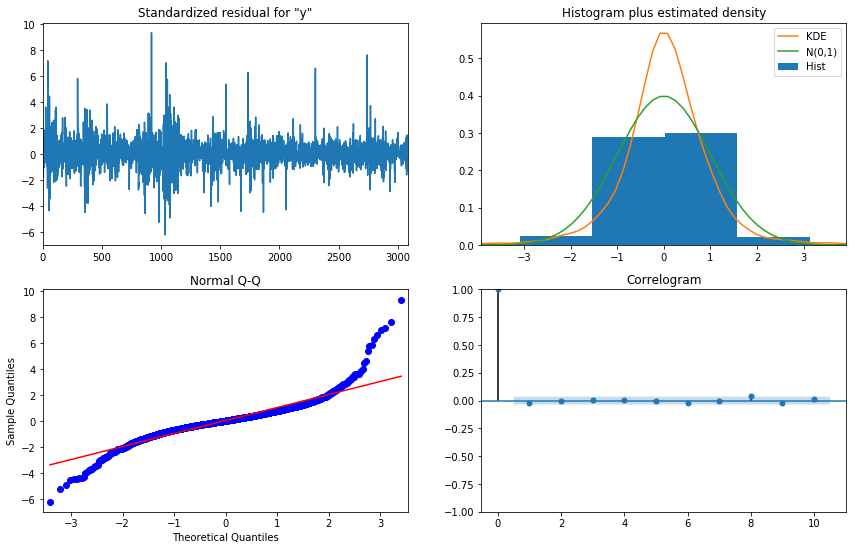

In [264]:
mod = sm.tsa.arima.ARIMA(endog=X_train.values, order=(2,0,2), trend='n', enforce_stationarity =False)
res = mod.fit(cov_type='robust')

print(res.summary())

import matplotlib as mpl
with mpl.rc_context():
    mpl.rc("figure", figsize=(9*1.6,9))
    res.plot_diagnostics()

In [267]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [269]:
adf_test(X_train)

Results of Dickey-Fuller Test:
Test Statistic                  -55.165131
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    3092.000000
Critical Value (1%)              -3.432467
Critical Value (5%)              -2.862475
Critical Value (10%)             -2.567268
dtype: float64


In [270]:
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [271]:
kpss_test(X_train)

Results of KPSS Test:
Test Statistic           0.254872
p-value                  0.100000
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\ashubert\Anaconda3\envs\gas_research\lib\site-packages\statsmodels\tsa\stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


**seasonality**

# Modelling

trend-stationarity:  
- you try to regress on time
- subtract trend --> work with residuals $\hat{y}_t = x_t - \hat{\mu_t}$, where $\mu_t$ - trend
- include lagged variables



transformations:
    - difference
    - regression with lagged variables
    - with dummies

*pre-whitening cross-correlation*

*scatter plot matrix*

seasonality

* seasonal-stationary

Trends can result in a varying mean over time, whereas seasonality can result in a changing variance over time, both which define a time series as being non-stationary. Stationary datasets are those that have a stable mean and variance, and are in turn much easier to model.

https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/

difference to remove seasonality

In [ ]:
When looking at relationships between two variables which are time series, seasonality will reduce the degrees of freedom because the data will not be independent. This "serial" correlation will result in spurious correlations. Thus the seasonality is removed with the goal of increasing the degrees of freedom.

In [ ]:
Average de-trended values.
Differencing a time-series.
Use the loess method.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
import matplotlib as mpl
with mpl.rc_context():
    mpl.rc("figure", figsize=(9*1.6,9))
    decompose_result = seasonal_decompose(google_rt, model="additive", period=12)

    trend = decompose_result.trend
    seasonal = decompose_result.seasonal
    residual = decompose_result.resid

    decompose_result.plot();

rolling means

In [ ]:
google_rt.rolling(window = 12).mean().plot(figsize=(8,4), color="tab:red", title="Rolling Mean over 12 month period");

In [ ]:
google_rt.rolling(window = 20).var().plot(figsize=(8,4), color="tab:red", title="Rolling variance over 20 period");


https://coderzcolumn.com/tutorials/data-science/how-to-remove-trend-and-seasonality-from-time-series-data-using-python-pandas

In [ ]:
Differencing Over Log Transformed Time-Series